#Importing libraries and dataset

In [ ]:
!git clone https://github.com/gkeechin/vizgradcam

Cloning into 'vizgradcam'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 67 (delta 32), reused 24 (delta 6), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [ ]:
cd /content/vizgradcam

/content/vizgradcam


In [ ]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

     |████████████████████████████████| 275 kB 4.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=438ba5cce01ccadd50ec8a7057c6fad297a885f572442ee3430d23dc4152cba7
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HEIGHT = 128
WIDTH = 128
CHANNELS = 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import keras.backend as K
import warnings
from sklearn.utils import compute_class_weight
import pywt

In [ ]:
tf.random.set_seed(42)

In [ ]:
images = []
classes_labels = []
for i in os.listdir("/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/train"):
  class_path = f"/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/train/{i}"
  # if(i == "Lung opacity"):
  #   continue
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    classes_labels.append(i)
    images.append(cv2.resize(cv2.imread(file_path, 1), (HEIGHT, WIDTH)))

In [ ]:
test_images = []
test_classes_labels = []
for i in os.listdir("/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/test"):
  class_path = f"/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/test/{i}"
  # if(i == "Lung opacity"):
  #   continue
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    test_classes_labels.append(i)
    test_images.append(cv2.resize(cv2.imread(file_path, 1), (HEIGHT, WIDTH)))

In [ ]:
train_images, validation_images, train_labels, validation_labels = train_test_split(images, classes_labels, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

In [ ]:
class_weights

array([1.30491474, 0.79914005, 0.60596181, 3.01157407])

In [ ]:
weights = dict(zip([0, 1, 2], class_weights))

In [ ]:
weights

{0: 1.304914744232698, 1: 0.7991400491400491, 2: 0.6059618071727992}

In [ ]:
train_images = np.asarray(train_images)
validation_images = np.asarray(validation_images)
train_labels = np.asarray(train_labels)
validation_labels = np.asarray(validation_labels)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
validation_labels = lb.transform(validation_labels)

In [ ]:
test_classes_labels = lb.transform(test_classes_labels)

In [ ]:
test_images = np.asarray(test_images)
test_classes_labels = np.asarray(test_classes_labels)

#Data Visualization

In [ ]:
def data(history):
  return pd.DataFrame(data=list(zip(history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"], history.history["recall"], history.history["val_recall"], history.history["precision"], history.history["val_precision"], history.history["auc"], history.history["val_auc"], history.history["specificity"], history.history["val_specificity"], history.history["sensitivity"], history.history["val_sensitivity"], history.history["mcc"], history.history["val_mcc"])) , columns=["Accuracy", "Validation Accuracy", "Loss", "Validation Loss", "Recall", "Validation Recall", "Precision", "Validation Precision", "AUC", "Validation AUC", "Specificity", "Validation Specificity" ,"Sensitivity", "Validation Sensitivity", "MCC", "Validation MCC"])

In [ ]:
def history_visualization(df):
  sns.set_style('darkgrid')
  nrow = 4
  ncol = 2
  df_columns = df.columns
  df_list = [df[col] for col in df]
  titles=["Accuracy Visualization", "Loss Visualization", "Recall Visualization", "Precision Visualization", "AUC Visualization", "Specificity Visualization", "Sensitivity Visualization", "MCC Visualization"]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 16))
  count = 0
  i = 0
  for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], x="Number of Epochs", legend="brief", label=df_columns[count], marker="o").set_title(titles[i])
        df_list[count+1].plot(ax=axes[r, c], x="Number of Epochs", legend="brief" ,label=df_columns[count+1], marker="o").set_title(titles[i])
        i+=1
        count+=2

In [ ]:
early_stoping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

#Custom Metrics using Tensorflow

In [ ]:
def true_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.linalg.diag_part(res), axis = 0)

def false_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def false_negative(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def true_negative(y_true, y_pred):
  y_true_res = tf.argmax(y_true)
  y_pred_res = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true_res, y_pred_res, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1), axis=0) - (false_negative(y_true, y_pred) + false_positive(y_true, y_pred) + true_positive(y_true, y_pred))

In [ ]:
def sensitivity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TP)
    den = float(TP + FN + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

def specificity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TN)
    den = float(TN + FP + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

In [ ]:
def mcc(y_true, y_pred):
  y_true = tf.argmax(y_true).numpy()
  y_pred = tf.argmax(y_pred).numpy()

  return tf.constant(matthews_corrcoef(y_true, y_pred))

In [ ]:
def f1_score(y_true, y_pred): 
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [ ]:
class ThresholdCallback(keras.callbacks.Callback):
  def __init__(self, threshold):
    self.threshold = threshold
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("val_loss") < self.threshold):
      self.model.stop_training = True

#Image Generator

In [ ]:
import collections, numpy

In [ ]:
from collections import Counter

In [ ]:
num_images = [3143, 5084, 6728, 1345]

In [ ]:
sum(num_images)

16300

In [ ]:
num_classes = len(num_images)-1

In [ ]:
beta_values = [(1 - (x / sum(num_images))) / num_classes for x in num_images]

In [ ]:
beta = dict(zip([0, 1, 2, 3], beta_values))

In [ ]:
image_generator = ImageDataGenerator(validation_split = 0.2, rescale=1./255)

In [ ]:
train_dataset = image_generator.flow(train_images, train_labels, shuffle=True, subset="training", seed=42)

In [ ]:
validation_dataset = image_generator.flow(validation_images, validation_labels, shuffle=True, subset="training", seed=42)

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_set = test_generator.flow(test_images, test_classes_labels, shuffle=False, seed=42)

In [ ]:
beta

{0: 0.26905930470347644,
 1: 0.22936605316973413,
 2: 0.19574642126789366,
 3: 0.3058282208588957}

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath="/content/model/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5", monitor="val_loss", save_weights_only=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience = 7, monitor = "val_loss", restore_best_weights = True, mode="min")

In [ ]:
threshold = ThresholdCallback(0.2)

In [ ]:
os.mkdir("/content/model")

#GradCAM

In [ ]:
import cv2

In [ ]:
def make_gradcam(image,model,layer):
  image = cv2.resize(image, (WIDTH, HEIGHT))
 
  image_1 = np.expand_dims(image, axis=0)
  preds = model.predict(image_1) 
  i = np.argmax(preds[0])
  # image_1 = image_1.astype('float32') / 255
  icam = GradCAM(model, i, layer) 
  heatmap = icam.compute_heatmap(image_1)
  heatmap = cv2.resize(heatmap, (WIDTH, HEIGHT))
  
  (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.7)
  return heatmap,output,i

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

#Base Resnet 18 Model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
KERNEL_SIZE = (3, 3)
INIT_SCHEME = tf.keras.initializers.GlorotUniform()
input = tf.keras.layers.Input(shape=(WIDTH, HEIGHT, CHANNELS))
out = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform())(input)
out = BatchNormalization()(out)
out = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")(out)

out1 = Conv2D(64, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out)
out1 = BatchNormalization()(out1)
out1 = tf.nn.relu(out1)
out1 = Conv2D(64, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out1)
out1 = BatchNormalization()(out1)
out1 = Add()([out, out1])
out1 = tf.nn.relu(out1)

out2 = Conv2D(64, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out1)
out2 = BatchNormalization()(out2)
out2 = tf.nn.relu(out2)
out2 = Conv2D(64, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out2)
out2 = BatchNormalization()(out2)
out2 = Add()([out1, out2])
out2 = tf.nn.relu(out2)

out3 = Conv2D(128, strides=2,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out2)
out3 = BatchNormalization()(out3)
out3 = tf.nn.relu(out3)
out3 = Conv2D(128, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out3)
out3 = BatchNormalization()(out3)
out2 = Conv2D(128, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")(out2)
out2 = BatchNormalization()(out2)
out3 = Add()([out2, out3])
out3 = tf.nn.relu(out3)

out4 = Conv2D(128, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out3)
out4 = BatchNormalization()(out4)
out4 = tf.nn.relu(out4)
out4 = Conv2D(128, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out4)
out4 = BatchNormalization()(out4)
out4 = Add()([out3, out4])
out4 = tf.nn.relu(out4)

out5 = Conv2D(256, strides=2,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out4)
out5 = BatchNormalization()(out5)
out5 = tf.nn.relu(out5)
out5 = Conv2D(256, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out5)
out5 = BatchNormalization()(out5)
out4 = Conv2D(256, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")(out4)
out4 = BatchNormalization()(out4)
out5 = Add()([out4, out5])
out5 = tf.nn.relu(out5)

out6 = Conv2D(256, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out5)
out6 = BatchNormalization()(out6)
out6 = tf.nn.relu(out6)
out6 = Conv2D(256, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out6)
out6 = BatchNormalization()(out6)
out6 = Add()([out5, out6])
out6 = tf.nn.relu(out6)

out7 = Conv2D(512, strides=2,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out6)
out7 = BatchNormalization()(out7)
out7 = tf.nn.relu(out7)
out7 = Conv2D(512, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out7)
out7 = BatchNormalization()(out7)
out6 = Conv2D(512, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")(out6)
out6 = BatchNormalization()(out6)
out7 = Add()([out6, out7])
out7 = tf.nn.relu(out7)

out8 = Conv2D(512, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out7)
out8 = BatchNormalization()(out8)
out8 = tf.nn.relu(out8)
out8 = Conv2D(512, strides=1,kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)(out8)
out8 = BatchNormalization()(out8)
out8 = Add()([out7, out8])
out8 = tf.nn.relu(out8)

out8 = GlobalAveragePooling2D()(out8)
out = Flatten()(out8)
out = Dense(4, activation="softmax")(out)
model = tf.keras.models.Model(inputs=[input], outputs=[out])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = tf.keras.initializers.GlorotUniform()

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer=tf.keras.initializers.GlorotUniform())
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        return out

In [ ]:
base_model_2 = keras.models.load_model("/content/drive/MyDrive/Special_Issue_COVID_Journal/base_model_epooch_4", custom_objects={"res_net18" : ResNet18, "specificity" : specificity, "sensitivity" : sensitivity, "mcc" : mcc, "f1_score" : f1_score})
resnet_18 = base_model_2.get_layer("res_net18")
first_model = []
first_weights = []
second_model = []
for i in resnet_18.layers:
  if("resnet_block" in i.name):
    for j in resnet_18.get_layer(i.name).layers:
      first_model.append(j.name)
      first_weights.append(resnet_18.get_layer(i.name).get_layer(j.name).get_weights())
  else:
      first_model.append(i.name)
      first_weights.append(resnet_18.get_layer(i.name).get_weights())
for i in model.layers:
  if "tf.nn.relu" in i.name:
    continue
  elif(i.name not in ["input_1", "dense", "flatten"]):
    second_model.append(i.name)
for i in second_model:
  for index, j in enumerate(first_model):
    if(i == j):
      print(f"Setting {i}")
      model.get_layer(i).set_weights(first_weights[index])
for i in model.layers:
  if('global_average' in i.name):
    print("Setting Global Average Pooling")
    model.get_layer(i.name).set_weights(first_weights[-1])

Setting conv2d
Setting batch_normalization
Setting max_pooling2d
Setting conv2d_1
Setting batch_normalization_1
Setting conv2d_2
Setting batch_normalization_2
Setting add
Setting conv2d_3
Setting batch_normalization_3
Setting conv2d_4
Setting batch_normalization_4
Setting add_1
Setting conv2d_5
Setting batch_normalization_5
Setting conv2d_7
Setting conv2d_6
Setting batch_normalization_7
Setting batch_normalization_6
Setting add_2
Setting conv2d_8
Setting batch_normalization_8
Setting conv2d_9
Setting batch_normalization_9
Setting add_3
Setting conv2d_10
Setting batch_normalization_10
Setting conv2d_12
Setting conv2d_11
Setting batch_normalization_12
Setting batch_normalization_11
Setting add_4
Setting conv2d_13
Setting batch_normalization_13
Setting conv2d_14
Setting batch_normalization_14
Setting add_5
Setting conv2d_15
Setting batch_normalization_15
Setting conv2d_17
Setting conv2d_16
Setting batch_normalization_17
Setting batch_normalization_16
Setting add_6
Setting conv2d_18
Settin

#ResNet18 with custom weights II

In [ ]:
weights = {
    0: 0.2867984508014418,
    1: 0.23652239435539535,
    2: 0.20130957128614158,
    3: 0.27361958355702126
}

In [ ]:
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
history = model.fit(x=train_dataset, validation_data=validation_dataset, epochs=25, batch_size=32, callbacks=[early_stopping, model_checkpoint], class_weight=weights)

Epoch 1/25
261/261 [==============================] - 56s 170ms/step - loss: 0.1109 - accuracy: 0.8236 - precision: 0.8427 - recall: 0.8037 - auc: 0.9621 - specificity: 0.1092 - sensitivity: 0.0881 - mcc: 0.1825 - val_loss: 2.6816 - val_accuracy: 0.5391 - val_precision: 0.5422 - val_recall: 0.5334 - val_auc: 0.7560 - val_specificity: 0.0682 - val_sensitivity: 0.0455 - val_mcc: 0.1339
Epoch 2/25
261/261 [==============================] - 44s 170ms/step - loss: 0.0683 - accuracy: 0.8914 - precision: 0.8996 - recall: 0.8839 - auc: 0.9839 - specificity: 0.1341 - sensitivity: 0.0881 - mcc: 0.1991 - val_loss: 1.1165 - val_accuracy: 0.5079 - val_precision: 0.5090 - val_recall: 0.5002 - val_auc: 0.8604 - val_specificity: 0.1288 - val_sensitivity: 0.0758 - val_mcc: 0.2214
Epoch 3/25
261/261 [==============================] - 44s 170ms/step - loss: 0.0539 - accuracy: 0.9176 - precision: 0.9218 - recall: 0.9134 - auc: 0.9890 - specificity: 0.1475 - sensitivity: 0.0575 - mcc: 0.1979 - val_loss: 0.

In [ ]:
df = data(history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.823586,0.539126,0.110879,2.681620,0.803651,0.533365,0.842715,0.542216,0.962102,0.755981,0.109195,0.068182,0.088123,0.045455,0.182465,0.133875
1,0.891437,0.507921,0.068350,1.116540,0.883872,0.500240,0.899646,0.509038,0.983859,0.860359,0.134100,0.128788,0.088123,0.075758,0.199052,0.221381
2,0.917617,0.816131,0.053885,0.570168,0.913414,0.794047,0.921828,0.826587,0.989043,0.949598,0.147510,0.090909,0.057471,0.136364,0.197942,0.216994
3,0.929146,0.465194,0.044265,3.191483,0.925423,0.460874,0.931914,0.466926,0.992402,0.717319,0.147510,0.060606,0.091954,0.060606,0.213535,0.155079
4,0.932389,0.748440,0.041317,0.959587,0.928666,0.741719,0.935859,0.756241,0.993758,0.913011,0.118774,0.166667,0.118774,0.068182,0.200573,0.205435
5,0.957488,0.766683,0.028504,0.823724,0.956887,0.759001,0.958960,0.776904,0.996354,0.928675,0.118774,0.121212,0.107280,0.121212,0.223287,0.191500
6,0.951363,0.897264,0.031491,0.300130,0.949081,0.895823,0.953432,0.902758,0.995906,0.983308,0.107280,0.136364,0.084291,0.136364,0.199250,0.213625
7,0.970217,0.721555,0.018873,1.188588,0.969617,0.711474,0.971834,0.725404,0.998376,0.898784,0.137931,0.141414,0.107280,0.106061,0.215291,0.226040
8,0.974661,0.667307,0.015815,1.106985,0.974180,0.655305,0.975352,0.674407,0.998771,0.887979,0.149425,0.035354,0.099617,0.030303,0.208753,0.134441
9,0.968536,0.542487,0.020407,3.409577,0.967936,0.540086,0.969216,0.544004,0.997786,0.752275,0.114943,0.340909,0.114943,0.189394,0.216667,0.305177


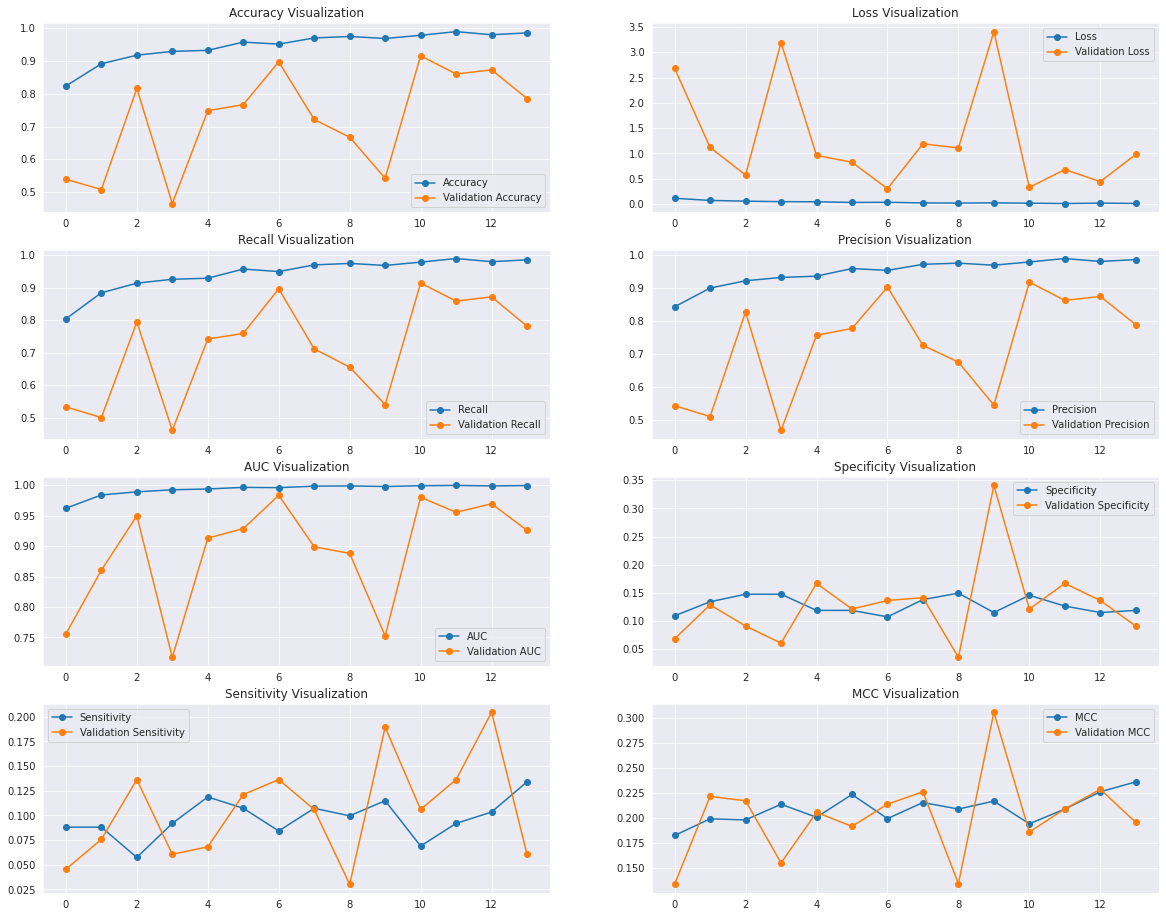

In [ ]:
history_visualization(df)

##Prediction

In [ ]:
model.load_weights("/content/model/my_best_model.epoch06-loss0.32.hdf5")

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(directory="/content/drive/MyDrive/Special_Issue_COVID_Journal/original_dataset/test", target_size=(HEIGHT, WIDTH), color_mode="rgb", class_mode="categorical", shuffle=False)

Found 3254 images belonging to 4 classes.


In [ ]:
test_dataset.class_indices

{'COVID': 0, 'Lung opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
train_dataset.class_indices

{'COVID': 0, 'Lung opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
predictions = model.predict(test_set)

In [ ]:
predictions_index = lb.inverse_transform(predictions)

In [ ]:
predictions_index = lb.inverse_transform(predictions)
print(classification_report(predictions_index, lb.inverse_transform(test_set.y)))

                 precision    recall  f1-score   support

          COVID       0.96      0.82      0.89       733
   Lung opacity       0.91      0.88      0.90      1055
         Normal       0.85      0.96      0.90      1194
Viral Pneumonia       0.97      0.96      0.96       272

       accuracy                           0.90      3254
      macro avg       0.92      0.90      0.91      3254
   weighted avg       0.91      0.90      0.90      3254



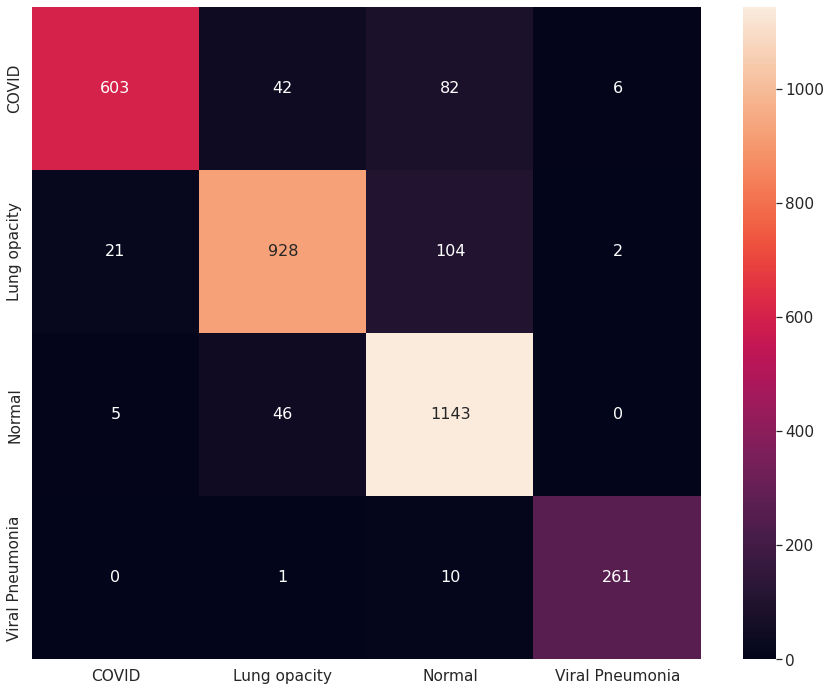

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(predictions_index, lb.inverse_transform(test_set.y))
df_cm = pd.DataFrame(cm, index = [i for i in lb.classes_],
                  columns = [i for i in lb.classes_])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve, roc_auc_score
bin = LabelBinarizer()
x_test = bin.fit_transform(lb.inverse_transform(test_set.y))
pred = bin.transform(predictions_index)
print(roc_auc_score(x_test, pred))

0.94480267079851


In [ ]:
tf.keras.models.save_model(model, "/content/custom")

INFO:tensorflow:Assets written to: /content/custom/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
!zip -r /content/6.zip /content/custom

  adding: content/custom/ (stored 0%)
  adding: content/custom/saved_model.pb (deflated 92%)
  adding: content/custom/variables/ (stored 0%)
  adding: content/custom/variables/variables.index (deflated 80%)
  adding: content/custom/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/custom/keras_metadata.pb (deflated 94%)
  adding: content/custom/assets/ (stored 0%)
